In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.bayesian_NN.NN_model import logprior, loglikelihood, init_network, get_accuracy_list_NN, get_ECE_MCE, ood_testing
from models.bayesian_NN.NN_data import X_train, y_train, X_test, y_test
from models.bayesian_NN.util import load_NN_MAP, add_noise_NN_params

from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed, flatten_param_list

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# NN

In [2]:


data = (X_train, y_train)

key = random.PRNGKey(0)

Niters = 1000
key, subkey = random.split(key)
params_IC = add_noise_NN_params(subkey, load_NN_MAP(), 1.)
batch_size = int(0.1*X_train.shape[0])

gridsearch_bs = int(0.1*X_train.shape[0])
centering_value = load_NN_MAP()

dt_baseline = 1/X_train.shape[0]

In [3]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)



def get_fb_grads_NN(samples):
    """
    Return full-batch gradients for NN samples
    samples list of NN sample. Each NN sample is a list of tuples
    """
    return [grad_log_post(sam, X_train, y_train) for sam in samples]

def assess_NN_samples(samples, thin_step):
    print(f"Assessing the samples. Num samples: {len(samples)}")
    num_samples = len(samples)
    flat_samples = flatten_param_list(samples[::thin_step])
    print("calculating ECE/MCE")
    ece_est, mce_est = get_ECE_MCE(flat_samples, X_test, y_test, M=10, pbar=False)
    print("calculating accuracy list")
    accuracy_list = get_accuracy_list_NN(samples, thin_step, X_test, y_test)
    
    return ece_est, mce_est, num_samples, accuracy_list, samples[::thin_step]
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_NN_MAP()):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_NN_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)


time_budget = 300
thin = 400

# time_budget = 7
# thin = 20


# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

### sgld

In [5]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgld_mamba, samples_sgld_mamba = run_time_budget(
                key, time_budget, partial_build_sgld, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 96922
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.010419734191894531, DeviceArray(0.36351842, dtype=float32), 96922)


0.93117684


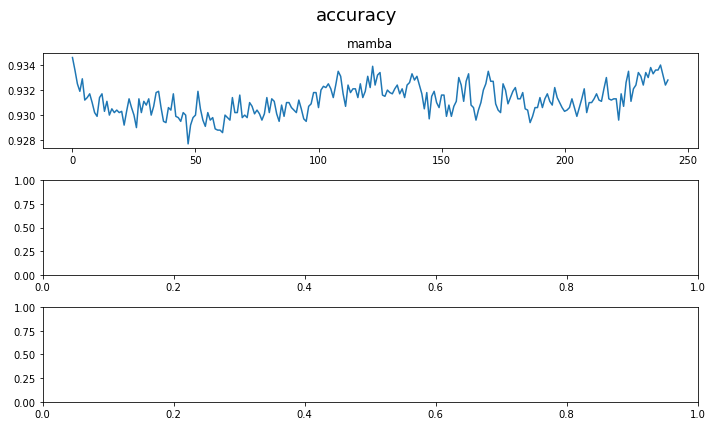

In [7]:
burnin_sgld_mamba = 10
burnin_sgld_gridsearch = 0
burnin_sgld_baseline = 0

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgld_mamba)
ax[0].set_title("mamba")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_mamba[burnin_sgld_mamba:]))

In [9]:
ood_entropy_samples_sgld_mamba = ood_testing(samples_sgld_mamba[burnin_sgld_mamba:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_mamba.txt", ood_entropy_samples_sgld_mamba)


In [12]:
# gridsearch
ece_est, mce_est, num_samples, accuracy_list_sgld_gridsearch, samples_sgld_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgld, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 16343
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.1460456787109375, DeviceArray(0.42104274, dtype=float32), 16343)


0.937836


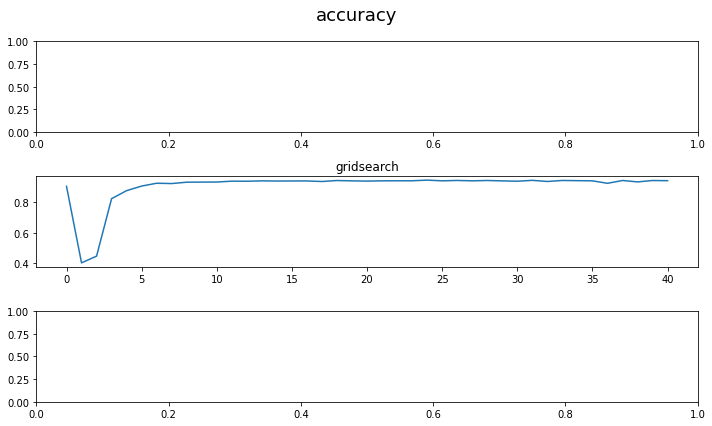

In [17]:
# burnin_sgld_mamba = 10
burnin_sgld_gridsearch = 5
# burnin_sgld_baseline = 0

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[1].plot(accuracy_list_sgld_gridsearch)
ax[1].set_title("gridsearch")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_gridsearch[burnin_sgld_gridsearch:]))

In [18]:
ood_entropy_samples_sgld_gridsearch = ood_testing(samples_sgld_gridsearch[burnin_sgld_gridsearch:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_gridsearch.txt", ood_entropy_samples_sgld_gridsearch)


In [19]:

ece_est, mce_est, num_samples, accuracy_list_sgld_baseline, samples_sgld_baseline = run_time_budget(
                key, time_budget, partial_build_sgld, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 15192
calculating ECE/MCE
calculating accuracy list



baseline: (0.008206493377685547, DeviceArray(0.23328367, dtype=float32), 15192)


0.9325182


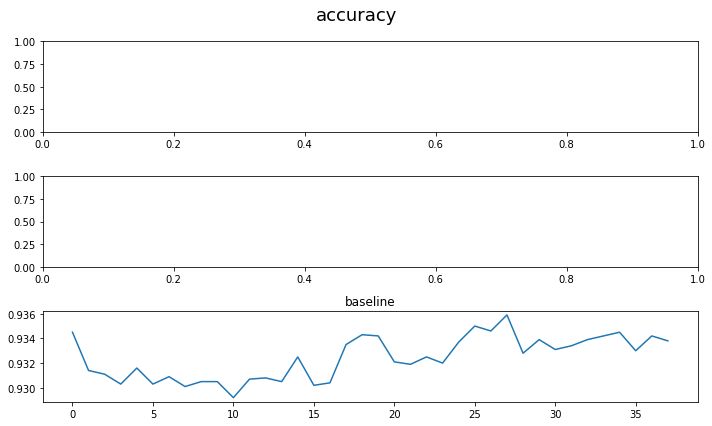

In [22]:
# burnin_sgld_mamba = 10
# burnin_sgld_gridsearch = 0
burnin_sgld_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[2].plot(accuracy_list_sgld_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgld_baseline[burnin_sgld_baseline:]))

In [23]:

ood_entropy_samples_sgld_baseline = ood_testing(samples_sgld_baseline[burnin_sgld_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgld_baseline.txt", ood_entropy_samples_sgld_baseline)



In [27]:

ood_entropy_samples_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_mamba.txt")
ood_entropy_samples_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_gridsearch.txt")
ood_entropy_samples_sgld_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgld_baseline.txt")


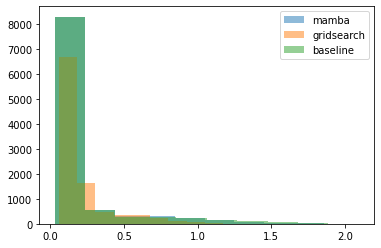

In [28]:

plt.hist(ood_entropy_samples_sgld_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgld_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgld_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgld-cv

In [29]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")



ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 64693
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.007949291229248047, DeviceArray(0.21330324, dtype=float32), 64693)


0.93103045


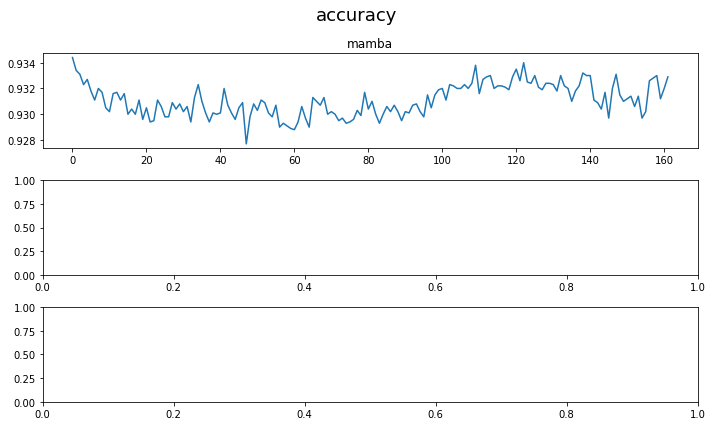

In [30]:
burnin_sgldCV_mamba = 5
burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgldCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgldCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgldCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
# print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
# print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))

In [31]:
ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
# ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
# ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [32]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")



Assessing the samples. Num samples: 9659
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.088268701171875, DeviceArray(0.40650263, dtype=float32), 9659)


0.942035


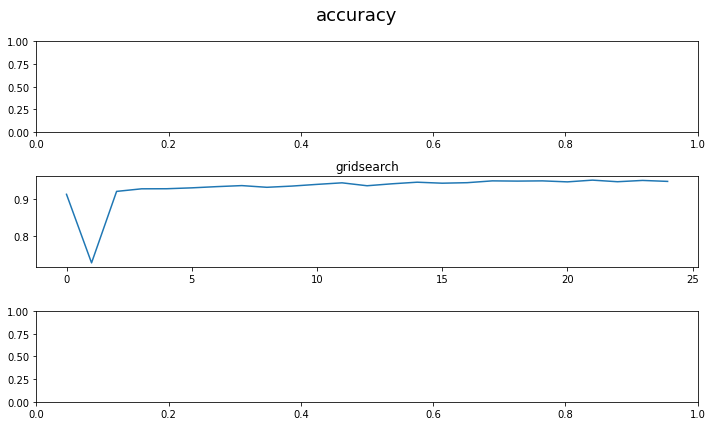

In [33]:
burnin_sgldCV_mamba = 5
burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgldCV_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sgldCV_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgldCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
# print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))

In [34]:
# ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
# ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [35]:
sh_params = {'batch_size': 600, 'dt': 3.1622776e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgldCV_mamba, samples_sgldCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgldCV_gridsearch, samples_sgldCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgldCV_baseline, samples_sgldCV_baseline = run_time_budget(
                key, time_budget, partial_build_sgldCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")



Assessing the samples. Num samples: 9534
calculating ECE/MCE
calculating accuracy list



baseline: (0.007145311737060547, DeviceArray(0.22008447, dtype=float32), 9534)


0.93174213


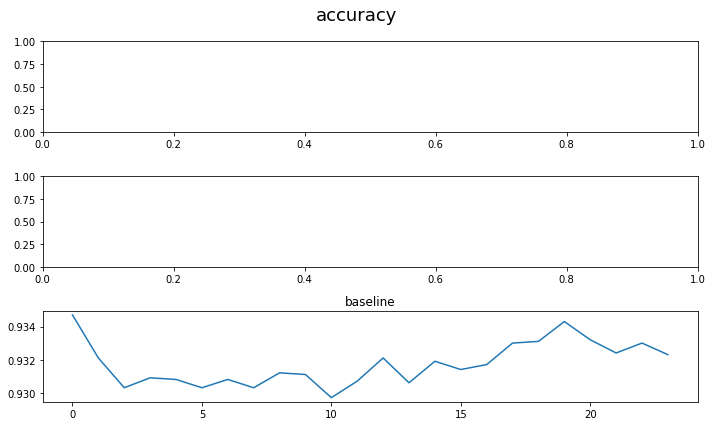

In [36]:
# burnin_sgldCV_mamba = 5
# burnin_sgldCV_gridsearch = 5
burnin_sgldCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgldCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgldCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgldCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
# print(np.mean(accuracy_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
print(np.mean(accuracy_list_sgldCV_baseline[burnin_sgldCV_baseline:]))


In [37]:
# ood_entropy_samples_sgldCV_mamba = ood_testing(samples_sgldCV_mamba[burnin_sgldCV_mamba:], X_test)
# ood_entropy_samples_sgldCV_gridsearch = ood_testing(samples_sgldCV_gridsearch[burnin_sgldCV_gridsearch:], X_test)
ood_entropy_samples_sgldCV_baseline = ood_testing(samples_sgldCV_baseline[burnin_sgldCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt", ood_entropy_samples_sgldCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt", ood_entropy_samples_sgldCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt", ood_entropy_samples_sgldCV_baseline)


In [56]:

# ood_entropy_samples_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_mamba.txt")
# ood_entropy_samples_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_gridsearch.txt")
# ood_entropy_samples_sgldCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgldCV_baseline.txt")


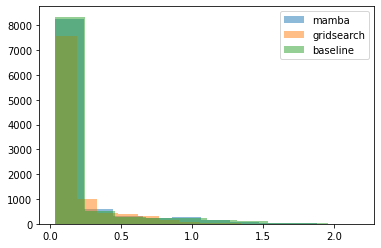

In [38]:


plt.hist(ood_entropy_samples_sgldCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgldCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgldCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sghmc

In [39]:
thin = 40

In [40]:
sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 23250
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.007436716461181641, DeviceArray(0.5613457, dtype=float32), 23250)


0.93015385


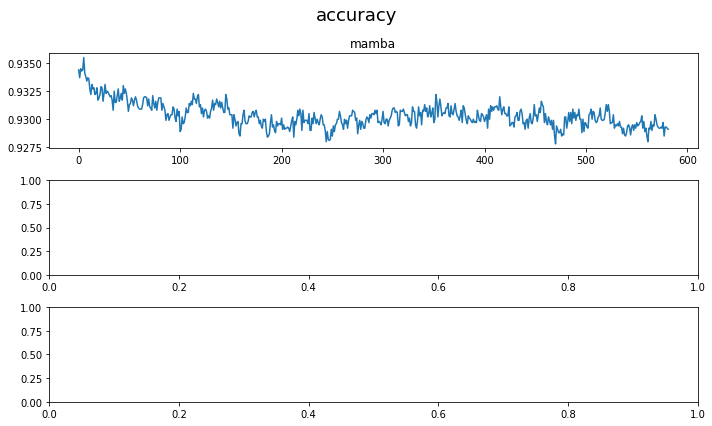

In [44]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 50
burnin_sghmc_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sghmc_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmc_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmc_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
# print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
# print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [45]:
ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
# ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
# ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)



In [49]:
thin = 5

sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1761
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.2066101806640625, DeviceArray(0.65530646, dtype=float32), 1761)


0.9246955


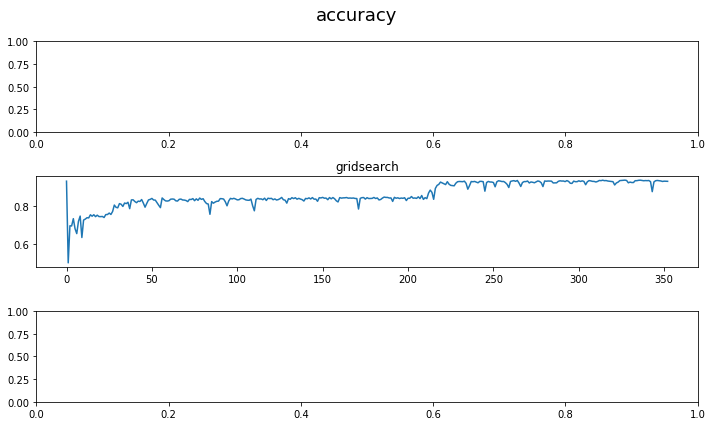

In [51]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 240
burnin_sghmc_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmc_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sghmc_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmc_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
# print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [52]:
# ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
# ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)


In [54]:
thin = 5
sh_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}


print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmc_mamba, samples_sghmc_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmc_gridsearch, samples_sghmc_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmc, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmc_baseline, samples_sghmc_baseline = run_time_budget(
                key, time_budget, partial_build_sghmc, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1717
calculating ECE/MCE
calculating accuracy list



baseline: (0.5094384765625, DeviceArray(0.71638095, dtype=float32), 1717)


0.9172324


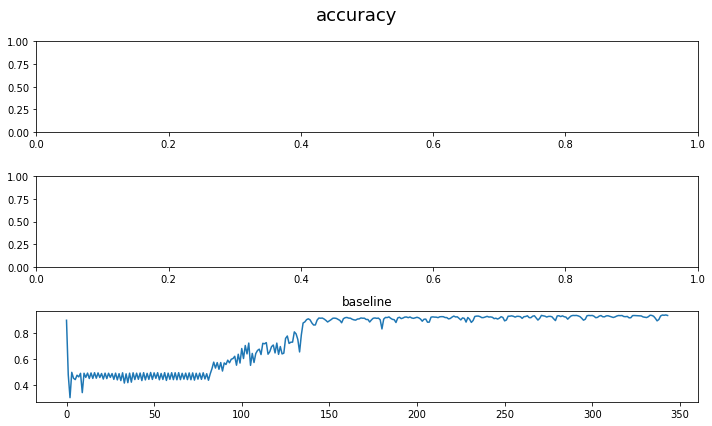

In [56]:
burnin_sghmc_mamba = 50
burnin_sghmc_gridsearch = 5
burnin_sghmc_baseline = 150

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmc_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmc_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sghmc_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmc_mamba[burnin_sghmc_mamba:]))
# print(np.mean(accuracy_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
print(np.mean(accuracy_list_sghmc_baseline[burnin_sghmc_baseline:]))


In [57]:
# ood_entropy_samples_sghmc_mamba = ood_testing(samples_sghmc_mamba[burnin_sghmc_mamba:], X_test)
# ood_entropy_samples_sghmc_gridsearch = ood_testing(samples_sghmc_gridsearch[burnin_sghmc_gridsearch:], X_test)
ood_entropy_samples_sghmc_baseline = ood_testing(samples_sghmc_baseline[burnin_sghmc_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt", ood_entropy_samples_sghmc_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt", ood_entropy_samples_sghmc_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt", ood_entropy_samples_sghmc_baseline)


In [58]:
# ood_entropy_samples_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_mamba.txt")
# ood_entropy_samples_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_gridsearch.txt")
# ood_entropy_samples_sghmc_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmc_baseline.txt")


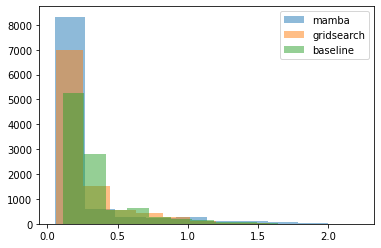

In [60]:


plt.hist(ood_entropy_samples_sghmc_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sghmc_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sghmc_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sghmc-cv

In [67]:
thin = 200

In [68]:
sh_params = {'batch_size': 60, 'L': 5, 'dt': 3.1622776e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_gridsearch, samples_sghmcCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_baseline, samples_sghmcCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 41028
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.0076224220275878905, DeviceArray(0.09610003, dtype=float32), 41028)


0.9295526


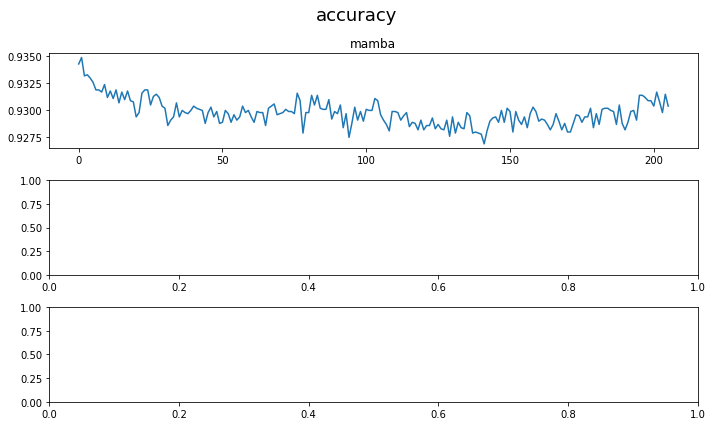

In [69]:
burnin_sghmcCV_mamba = 20
burnin_sghmcCV_gridsearch = 5
burnin_sghmcCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sghmcCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmcCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmcCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
# print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
# print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [70]:
ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
# ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
# ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [78]:
thin = 3
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}

print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmcCV_gridsearch, samples_sghmcCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_baseline, samples_sghmcCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 1013
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.2515013671875, DeviceArray(0.5520834, dtype=float32), 1013)


0.828642


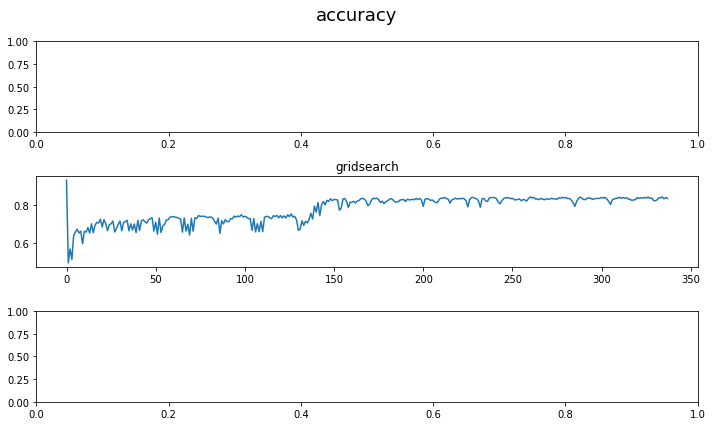

In [86]:
burnin_sghmcCV_mamba = 5
burnin_sghmcCV_gridsearch = 150
burnin_sghmcCV_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmcCV_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sghmcCV_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sghmcCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
# print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [87]:
# ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
# ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [81]:
thin = 5
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_mamba, samples_sghmcCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sghmcCV_gridsearch, samples_sghmcCV_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sghmcCV_baseline, samples_sghmcCV_baseline = run_time_budget(
                key, time_budget, partial_build_sghmcCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 984
calculating ECE/MCE
calculating accuracy list



baseline: (0.4078271484375, DeviceArray(0.74838185, dtype=float32), 984)


0.90065366


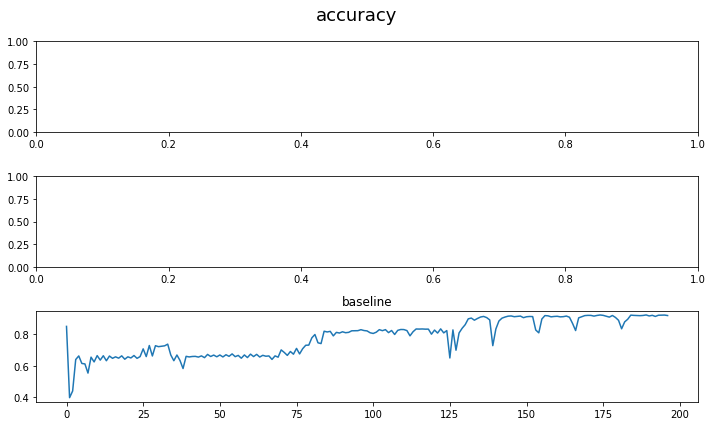

In [84]:
burnin_sghmcCV_mamba = 5
burnin_sghmcCV_gridsearch = 5
burnin_sghmcCV_baseline = 130

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sghmcCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sghmcCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sghmcCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
# print(np.mean(accuracy_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
print(np.mean(accuracy_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))


In [85]:
# ood_entropy_samples_sghmcCV_mamba = ood_testing(samples_sghmcCV_mamba[burnin_sghmcCV_mamba:], X_test)
# ood_entropy_samples_sghmcCV_gridsearch = ood_testing(samples_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:], X_test)
ood_entropy_samples_sghmcCV_baseline = ood_testing(samples_sghmcCV_baseline[burnin_sghmcCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt", ood_entropy_samples_sghmcCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt", ood_entropy_samples_sghmcCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt", ood_entropy_samples_sghmcCV_baseline)


In [91]:

# ood_entropy_samples_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_mamba.txt")
# ood_entropy_samples_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_gridsearch.txt")
# ood_entropy_samples_sghmcCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sghmcCV_baseline.txt")


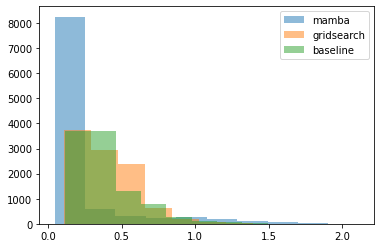

In [90]:


plt.hist(ood_entropy_samples_sghmcCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sghmcCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sghmcCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgnht

In [ ]:
thin = 400
sh_params = {'batch_size': 60, 'dt': 1e-05} 

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


In [ ]:
burnin_sgnht_mamba = 5
burnin_sgnht_gridsearch = 5
burnin_sgnht_baseline = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgnht_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnht_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnht_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
# print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
# print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [89]:
ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
# ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
# ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [8]:
thin = 100
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 1e-4}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 15412
calculating ECE/MCE


ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
burnin_sgnht_gridsearch = 5

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnht_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sgnht_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnht_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
# print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [ ]:
# ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
# ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [9]:
thin = 100
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

# print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgnht_mamba, samples_sgnht_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnht_gridsearch, samples_sgnht_gridsearch = run_time_budget(
#                 key, time_budget, partial_build_sgnht, thin, gridsearch_params)
# print(f"gridsearch: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgnht_baseline, samples_sgnht_baseline = run_time_budget(
                key, time_budget, partial_build_sgnht, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


Assessing the samples. Num samples: 16727
calculating ECE/MCE
calculating accuracy list



baseline: (0.062427630615234375, DeviceArray(0.43218303, dtype=float32), 16727)


0.9524306


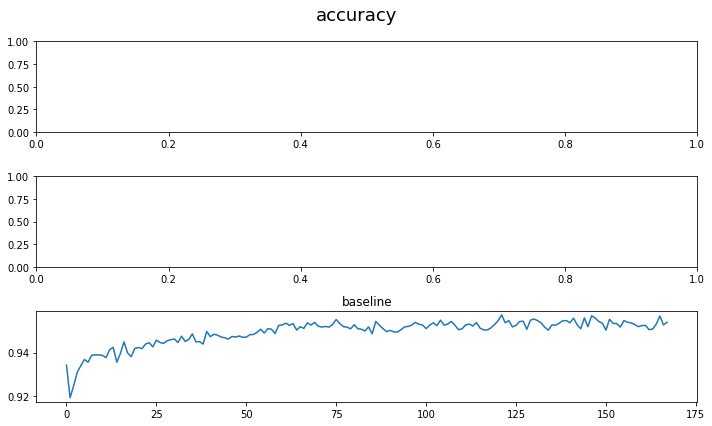

In [12]:
burnin_sgnht_baseline = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnht_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnht_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgnht_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnht_mamba[burnin_sgnht_mamba:]))
# print(np.mean(accuracy_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
print(np.mean(accuracy_list_sgnht_baseline[burnin_sgnht_baseline:]))


In [13]:
# ood_entropy_samples_sgnht_mamba = ood_testing(samples_sgnht_mamba[burnin_sgnht_mamba:], X_test)
# ood_entropy_samples_sgnht_gridsearch = ood_testing(samples_sgnht_gridsearch[burnin_sgnht_gridsearch:], X_test)
ood_entropy_samples_sgnht_baseline = ood_testing(samples_sgnht_baseline[burnin_sgnht_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt", ood_entropy_samples_sgnht_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt", ood_entropy_samples_sgnht_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt", ood_entropy_samples_sgnht_baseline)


In [14]:

# ood_entropy_samples_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_mamba.txt")
# ood_entropy_samples_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_gridsearch.txt")
# ood_entropy_samples_sgnht_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnht_baseline.txt")


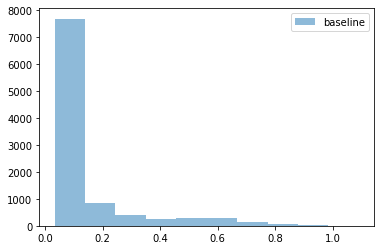

In [18]:


# plt.hist(ood_entropy_samples_sgnht_mamba, label='mamba', alpha=0.5)
# plt.hist(ood_entropy_samples_sgnht_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgnht_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


### sgnht-cv

In [19]:
thin = 100
sh_params = {'batch_size': 600, 'dt': 3.1622776e-08}

print("ece_est, mce_est, num_samples:\n")
ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_mamba, samples_sgnhtCV_mamba = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, sh_params)
print(f"MAMBA: {ece_est, mce_est, num_samples}")



ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 63872
calculating ECE/MCE
calculating accuracy list



MAMBA: (0.008847965240478515, DeviceArray(0.2969753, dtype=float32), 63872)


0.93077576


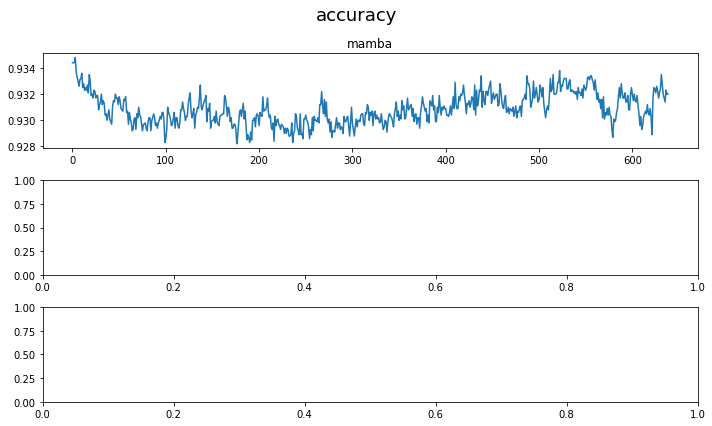

In [22]:
burnin_sgnhtCV_mamba = 50

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
ax[0].plot(accuracy_list_sgnhtCV_mamba)
ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
# ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnhtCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(accuracy_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
# print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
# print(np.mean(accuracy_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))


In [23]:
ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)
# ood_entropy_samples_sgnhtCV_gridsearch = ood_testing(samples_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:], X_test)
# ood_entropy_samples_sgnhtCV_baseline = ood_testing(samples_sgnhtCV_baseline[burnin_sgnhtCV_baseline:], X_test)

np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt", ood_entropy_samples_sgnhtCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt", ood_entropy_samples_sgnhtCV_baseline)


In [36]:
9000/20

450.0

In [37]:
thin = 20
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}

print("ece_est, mce_est, num_samples:\n")
# ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_mamba, samples_sgnhtCV_mamba = run_time_budget(
#                 key, time_budget, partial_build_sgnhtCV, thin, sh_params)
# print(f"MAMBA: {ece_est, mce_est, num_samples}")

ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_gridsearch, samples_sgnhtCV_gridsearch = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params)
print(f"gridsearch: {ece_est, mce_est, num_samples}")

# ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_baseline, samples_sgnhtCV_baseline = run_time_budget(
#                 key, time_budget, partial_build_sgnhtCV, thin, baseline_params)
# print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 9372
calculating ECE/MCE
calculating accuracy list



gridsearch: (0.07727735595703125, DeviceArray(0.4239751, dtype=float32), 9372)


0.94647706


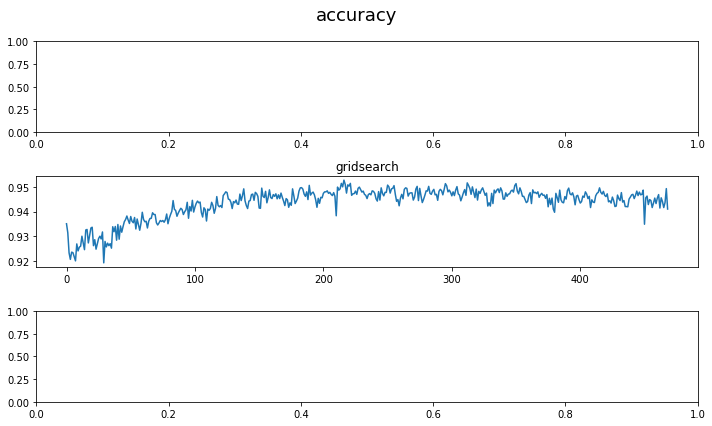

In [43]:

burnin_sgnhtCV_gridsearch = 150

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnhtCV_mamba)
# ax[0].set_title("mamba")
ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
ax[1].set_title("gridsearch")
# ax[2].plot(accuracy_list_sgnhtCV_baseline)
# ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
# print(np.mean(accuracy_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))


In [44]:
# ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)
ood_entropy_samples_sgnhtCV_gridsearch = ood_testing(samples_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:], X_test)
# ood_entropy_samples_sgnhtCV_baseline = ood_testing(samples_sgnhtCV_baseline[burnin_sgnhtCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt", ood_entropy_samples_sgnhtCV_gridsearch)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt", ood_entropy_samples_sgnhtCV_baseline)


In [40]:
thin = 20
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ece_est, mce_est, num_samples:\n")

ece_est, mce_est, num_samples, accuracy_list_sgnhtCV_baseline, samples_sgnhtCV_baseline = run_time_budget(
                key, time_budget, partial_build_sgnhtCV, thin, baseline_params)
print(f"baseline: {ece_est, mce_est, num_samples}")


ece_est, mce_est, num_samples:

Assessing the samples. Num samples: 9382
calculating ECE/MCE
calculating accuracy list



baseline: (0.06987108154296875, DeviceArray(0.51542866, dtype=float32), 9382)


0.9498266


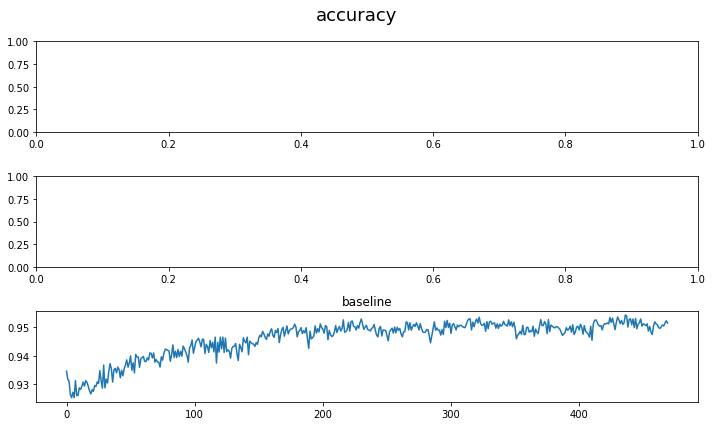

In [45]:
burnin_sgnhtCV_baseline = 200

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("accuracy", size=18)
# ax[0].plot(accuracy_list_sgnhtCV_mamba)
# ax[0].set_title("mamba")
# ax[1].plot(accuracy_list_sgnhtCV_gridsearch)
# ax[1].set_title("gridsearch")
ax[2].plot(accuracy_list_sgnhtCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

# print(np.mean(accuracy_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
# print(np.mean(accuracy_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
print(np.mean(accuracy_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))


In [46]:
# ood_entropy_samples_sgnhtCV_mamba = ood_testing(samples_sgnhtCV_mamba[burnin_sgnhtCV_mamba:], X_test)
# ood_entropy_samples_sgnhtCV_gridsearch = ood_testing(samples_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:], X_test)
ood_entropy_samples_sgnhtCV_baseline = ood_testing(samples_sgnhtCV_baseline[burnin_sgnhtCV_baseline:], X_test)

# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt", ood_entropy_samples_sgnhtCV_mamba)
# np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt", ood_entropy_samples_sgnhtCV_gridsearch)
np.savetxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt", ood_entropy_samples_sgnhtCV_baseline)


In [51]:

# ood_entropy_samples_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_mamba.txt")
# ood_entropy_samples_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_gridsearch.txt")
# ood_entropy_samples_sgnhtCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/ood/ood_sgnhtCV_baseline.txt")


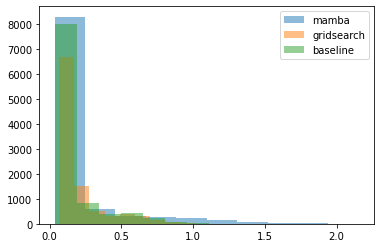

In [50]:


plt.hist(ood_entropy_samples_sgnhtCV_mamba, label='mamba', alpha=0.5)
plt.hist(ood_entropy_samples_sgnhtCV_gridsearch, label='gridsearch', alpha=0.5)
plt.hist(ood_entropy_samples_sgnhtCV_baseline, label='baseline', alpha=0.5)

plt.legend()
plt.show()


# 2. KSD curves

### sgld

In [5]:
error_fn_ksd_curve = partial(get_ksd_NN, thin_step=20)
list_time_budget = [2, 4, 6, 8, 10]

num_curves = 5

In [6]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/5
Budget: 2, num_samples = 856
Budget: 4, num_samples = 1365
Budget: 6, num_samples = 2027
Budget: 8, num_samples = 2917
Budget: 10, num_samples = 4006

Iteration 1/5
Budget: 2, num_samples = 923
Budget: 4, num_samples = 1668
Budget: 6, num_samples = 2283
Budget: 8, num_samples = 3237
Budget: 10, num_samples = 3997

Iteration 2/5
Budget: 2, num_samples = 921
Budget: 4, num_samples = 1490
Budget: 6, num_samples = 2238
Budget: 8, num_samples = 3191
Budget: 10, num_samples = 3680

Iteration 3/5
Budget: 2, num_samples = 889
Budget: 4, num_samples = 1384
Budget: 6, num_samples = 2234
Budget: 8, num_samples = 3133
Budget: 10, num_samples = 4096

Iteration 4/5
Budget: 2, num_samples = 925
Budget: 4, num_samples = 1467
Budget: 6, num_samples = 2176
Budget: 8, num_samples = 3210
Budget: 10, num_samples = 4054


In [7]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/5
Budget: 2, num_samples = 137
Budget: 4, num_samples = 265
Budget: 6, num_samples = 355
Budget: 8, num_samples = 405
Budget: 10, num_samples = 540

Iteration 1/5
Budget: 2, num_samples = 110
Budget: 4, num_samples = 219
Budget: 6, num_samples = 328
Budget: 8, num_samples = 443
Budget: 10, num_samples = 562

Iteration 2/5
Budget: 2, num_samples = 107
Budget: 4, num_samples = 214
Budget: 6, num_samples = 331
Budget: 8, num_samples = 447
Budget: 10, num_samples = 538

Iteration 3/5
Budget: 2, num_samples = 110
Budget: 4, num_samples = 212
Budget: 6, num_samples = 319
Budget: 8, num_samples = 423
Budget: 10, num_samples = 509

Iteration 4/5
Budget: 2, num_samples = 86
Budget: 4, num_samples = 198
Budget: 6, num_samples = 269
Budget: 8, num_samples = 338
Budget: 10, num_samples = 481


In [8]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 114
Budget: 4, num_samples = 196
Budget: 6, num_samples = 254
Budget: 8, num_samples = 343
Budget: 10, num_samples = 454

Iteration 1/5
Budget: 2, num_samples = 95
Budget: 4, num_samples = 177
Budget: 6, num_samples = 287
Budget: 8, num_samples = 350
Budget: 10, num_samples = 434

Iteration 2/5
Budget: 2, num_samples = 87
Budget: 4, num_samples = 157
Budget: 6, num_samples = 272
Budget: 8, num_samples = 349
Budget: 10, num_samples = 504

Iteration 3/5
Budget: 2, num_samples = 109
Budget: 4, num_samples = 218
Budget: 6, num_samples = 336
Budget: 8, num_samples = 429
Budget: 10, num_samples = 483

Iteration 4/5
Budget: 2, num_samples = 92
Budget: 4, num_samples = 180
Budget: 6, num_samples = 288
Budget: 8, num_samples = 350
Budget: 10, num_samples = 442


### sgld-cv

In [9]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/5
Budget: 2, num_samples = 549
Budget: 4, num_samples = 734
Budget: 6, num_samples = 1086
Budget: 8, num_samples = 1311
Budget: 10, num_samples = 1702

Iteration 1/5
Budget: 2, num_samples = 343
Budget: 4, num_samples = 703
Budget: 6, num_samples = 1018
Budget: 8, num_samples = 1551
Budget: 10, num_samples = 1858

Iteration 2/5
Budget: 2, num_samples = 402
Budget: 4, num_samples = 780
Budget: 6, num_samples = 1204
Budget: 8, num_samples = 1596
Budget: 10, num_samples = 1836

Iteration 3/5
Budget: 2, num_samples = 396
Budget: 4, num_samples = 827
Budget: 6, num_samples = 1019
Budget: 8, num_samples = 1561
Budget: 10, num_samples = 2058

Iteration 4/5
Budget: 2, num_samples = 432
Budget: 4, num_samples = 750
Budget: 6, num_samples = 1140
Budget: 8, num_samples = 1505
Budget: 10, num_samples = 2004


In [10]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/5
Budget: 2, num_samples = 60
Budget: 4, num_samples = 104
Budget: 6, num_samples = 145
Budget: 8, num_samples = 197
Budget: 10, num_samples = 265

Iteration 1/5
Budget: 2, num_samples = 57
Budget: 4, num_samples = 105
Budget: 6, num_samples = 140
Budget: 8, num_samples = 206
Budget: 10, num_samples = 237

Iteration 2/5
Budget: 2, num_samples = 50
Budget: 4, num_samples = 96
Budget: 6, num_samples = 157
Budget: 8, num_samples = 204
Budget: 10, num_samples = 278

Iteration 3/5
Budget: 2, num_samples = 53
Budget: 4, num_samples = 110
Budget: 6, num_samples = 144
Budget: 8, num_samples = 191
Budget: 10, num_samples = 281

Iteration 4/5
Budget: 2, num_samples = 60
Budget: 4, num_samples = 117
Budget: 6, num_samples = 144
Budget: 8, num_samples = 194
Budget: 10, num_samples = 264


In [11]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 76
Budget: 4, num_samples = 127
Budget: 6, num_samples = 171
Budget: 8, num_samples = 202
Budget: 10, num_samples = 280

Iteration 1/5
Budget: 2, num_samples = 60
Budget: 4, num_samples = 117
Budget: 6, num_samples = 170
Budget: 8, num_samples = 223
Budget: 10, num_samples = 304

Iteration 2/5
Budget: 2, num_samples = 65
Budget: 4, num_samples = 128
Budget: 6, num_samples = 191
Budget: 8, num_samples = 248
Budget: 10, num_samples = 300

Iteration 3/5
Budget: 2, num_samples = 63
Budget: 4, num_samples = 124
Budget: 6, num_samples = 193
Budget: 8, num_samples = 247
Budget: 10, num_samples = 307

Iteration 4/5
Budget: 2, num_samples = 62
Budget: 4, num_samples = 124
Budget: 6, num_samples = 193
Budget: 8, num_samples = 256
Budget: 10, num_samples = 315


### sghmc

In [12]:
dict_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}

Iteration 0/5
Budget: 2, num_samples = 187
Budget: 4, num_samples = 308
Budget: 6, num_samples = 414
Budget: 8, num_samples = 498
Budget: 10, num_samples = 653

Iteration 1/5
Budget: 2, num_samples = 135
Budget: 4, num_samples = 294
Budget: 6, num_samples = 396
Budget: 8, num_samples = 548
Budget: 10, num_samples = 628

Iteration 2/5
Budget: 2, num_samples = 144
Budget: 4, num_samples = 259
Budget: 6, num_samples = 360
Budget: 8, num_samples = 500
Budget: 10, num_samples = 667

Iteration 3/5
Budget: 2, num_samples = 127
Budget: 4, num_samples = 249
Budget: 6, num_samples = 409
Budget: 8, num_samples = 518
Budget: 10, num_samples = 662

Iteration 4/5
Budget: 2, num_samples = 128
Budget: 4, num_samples = 272
Budget: 6, num_samples = 394
Budget: 8, num_samples = 557
Budget: 10, num_samples = 679


In [13]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 14
Budget: 4, num_samples = 24
Budget: 6, num_samples = 34
Budget: 8, num_samples = 43
Budget: 10, num_samples = 54

Iteration 1/5
Budget: 2, num_samples = 12
Budget: 4, num_samples = 23
Budget: 6, num_samples = 33
Budget: 8, num_samples = 45
Budget: 10, num_samples = 56

Iteration 2/5
Budget: 2, num_samples = 12
Budget: 4, num_samples = 24
Budget: 6, num_samples = 33
Budget: 8, num_samples = 43
Budget: 10, num_samples = 57

Iteration 3/5
Budget: 2, num_samples = 13
Budget: 4, num_samples = 24
Budget: 6, num_samples = 34
Budget: 8, num_samples = 40
Budget: 10, num_samples = 56

Iteration 4/5
Budget: 2, num_samples = 12
Budget: 4, num_samples = 25
Budget: 6, num_samples = 33
Budget: 8, num_samples = 39
Budget: 10, num_samples = 41


In [14]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 15
Budget: 4, num_samples = 25
Budget: 6, num_samples = 32
Budget: 8, num_samples = 42
Budget: 10, num_samples = 57

Iteration 1/5
Budget: 2, num_samples = 13
Budget: 4, num_samples = 22
Budget: 6, num_samples = 34
Budget: 8, num_samples = 46
Budget: 10, num_samples = 57

Iteration 2/5
Budget: 2, num_samples = 11
Budget: 4, num_samples = 24
Budget: 6, num_samples = 31
Budget: 8, num_samples = 43
Budget: 10, num_samples = 57

Iteration 3/5
Budget: 2, num_samples = 11
Budget: 4, num_samples = 20
Budget: 6, num_samples = 34
Budget: 8, num_samples = 48
Budget: 10, num_samples = 62

Iteration 4/5
Budget: 2, num_samples = 13
Budget: 4, num_samples = 25
Budget: 6, num_samples = 36
Budget: 8, num_samples = 48
Budget: 10, num_samples = 57


### sghmc-CV

In [15]:
dict_params = {'batch_size': 60, 'L': 5, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 60, 'L': 5, 'dt': 3.1622776e-07}

Iteration 0/5
Budget: 2, num_samples = 335
Budget: 4, num_samples = 548
Budget: 6, num_samples = 737
Budget: 8, num_samples = 1051
Budget: 10, num_samples = 1319

Iteration 1/5
Budget: 2, num_samples = 232
Budget: 4, num_samples = 517
Budget: 6, num_samples = 799
Budget: 8, num_samples = 1045
Budget: 10, num_samples = 1294

Iteration 2/5
Budget: 2, num_samples = 226
Budget: 4, num_samples = 485
Budget: 6, num_samples = 736
Budget: 8, num_samples = 1002
Budget: 10, num_samples = 1277

Iteration 3/5
Budget: 2, num_samples = 237
Budget: 4, num_samples = 516
Budget: 6, num_samples = 775
Budget: 8, num_samples = 1026
Budget: 10, num_samples = 1252

Iteration 4/5
Budget: 2, num_samples = 242
Budget: 4, num_samples = 513
Budget: 6, num_samples = 772
Budget: 8, num_samples = 1010
Budget: 10, num_samples = 1305


In [16]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 10
Budget: 4, num_samples = 16
Budget: 6, num_samples = 20
Budget: 8, num_samples = 26
Budget: 10, num_samples = 33

Iteration 1/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 22
Budget: 8, num_samples = 28
Budget: 10, num_samples = 34

Iteration 2/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 20
Budget: 8, num_samples = 27
Budget: 10, num_samples = 34

Iteration 3/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 15
Budget: 6, num_samples = 21
Budget: 8, num_samples = 27
Budget: 10, num_samples = 32

Iteration 4/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 21
Budget: 8, num_samples = 26
Budget: 10, num_samples = 32


In [17]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 10
Budget: 4, num_samples = 15
Budget: 6, num_samples = 20
Budget: 8, num_samples = 26
Budget: 10, num_samples = 32

Iteration 1/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 20
Budget: 8, num_samples = 26
Budget: 10, num_samples = 33

Iteration 2/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 20
Budget: 8, num_samples = 25
Budget: 10, num_samples = 33

Iteration 3/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 20
Budget: 8, num_samples = 26
Budget: 10, num_samples = 32

Iteration 4/5
Budget: 2, num_samples = 8
Budget: 4, num_samples = 14
Budget: 6, num_samples = 20
Budget: 8, num_samples = 27
Budget: 10, num_samples = 33


### sgnht

In [18]:
dict_params = {'batch_size': 60, 'dt': 1e-05} 
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 60, 'dt': 1e-05}

Iteration 0/5
Budget: 2, num_samples = 1573
Budget: 4, num_samples = 2206
Budget: 6, num_samples = 3680
Budget: 8, num_samples = 4792
Budget: 10, num_samples = 6012

Iteration 1/5
Budget: 2, num_samples = 1538
Budget: 4, num_samples = 2123
Budget: 6, num_samples = 3635
Budget: 8, num_samples = 5508
Budget: 10, num_samples = 5774

Iteration 2/5
Budget: 2, num_samples = 1539
Budget: 4, num_samples = 2211
Budget: 6, num_samples = 3627
Budget: 8, num_samples = 5519
Budget: 10, num_samples = 6533

Iteration 3/5
Budget: 2, num_samples = 1522
Budget: 4, num_samples = 2415
Budget: 6, num_samples = 3678
Budget: 8, num_samples = 5251
Budget: 10, num_samples = 5249

Iteration 4/5
Budget: 2, num_samples = 1557
Budget: 4, num_samples = 2258
Budget: 6, num_samples = 3560
Budget: 8, num_samples = 5083
Budget: 10, num_samples = 5108


In [19]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-4}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.0001}

Iteration 0/5
Budget: 2, num_samples = 134
Budget: 4, num_samples = 250
Budget: 6, num_samples = 285
Budget: 8, num_samples = 347
Budget: 10, num_samples = 473

Iteration 1/5
Budget: 2, num_samples = 95
Budget: 4, num_samples = 187
Budget: 6, num_samples = 277
Budget: 8, num_samples = 375
Budget: 10, num_samples = 473

Iteration 2/5
Budget: 2, num_samples = 100
Budget: 4, num_samples = 200
Budget: 6, num_samples = 293
Budget: 8, num_samples = 395
Budget: 10, num_samples = 474

Iteration 3/5
Budget: 2, num_samples = 100
Budget: 4, num_samples = 199
Budget: 6, num_samples = 287
Budget: 8, num_samples = 362
Budget: 10, num_samples = 387

Iteration 4/5
Budget: 2, num_samples = 92
Budget: 4, num_samples = 187
Budget: 6, num_samples = 291
Budget: 8, num_samples = 364
Budget: 10, num_samples = 433


In [20]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 119
Budget: 4, num_samples = 199
Budget: 6, num_samples = 243
Budget: 8, num_samples = 342
Budget: 10, num_samples = 447

Iteration 1/5
Budget: 2, num_samples = 96
Budget: 4, num_samples = 180
Budget: 6, num_samples = 250
Budget: 8, num_samples = 365
Budget: 10, num_samples = 466

Iteration 2/5
Budget: 2, num_samples = 79
Budget: 4, num_samples = 173
Budget: 6, num_samples = 274
Budget: 8, num_samples = 384
Budget: 10, num_samples = 445

Iteration 3/5
Budget: 2, num_samples = 84
Budget: 4, num_samples = 147
Budget: 6, num_samples = 230
Budget: 8, num_samples = 368
Budget: 10, num_samples = 483

Iteration 4/5
Budget: 2, num_samples = 98
Budget: 4, num_samples = 202
Budget: 6, num_samples = 293
Budget: 8, num_samples = 387
Budget: 10, num_samples = 480


### sgnht-CV

In [21]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-08}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-08}

Iteration 0/5
Budget: 2, num_samples = 567
Budget: 4, num_samples = 777
Budget: 6, num_samples = 980
Budget: 8, num_samples = 1625
Budget: 10, num_samples = 2107

Iteration 1/5
Budget: 2, num_samples = 389
Budget: 4, num_samples = 710
Budget: 6, num_samples = 789
Budget: 8, num_samples = 1470
Budget: 10, num_samples = 1952

Iteration 2/5
Budget: 2, num_samples = 455
Budget: 4, num_samples = 863
Budget: 6, num_samples = 1216
Budget: 8, num_samples = 1682
Budget: 10, num_samples = 2192

Iteration 3/5
Budget: 2, num_samples = 487
Budget: 4, num_samples = 883
Budget: 6, num_samples = 1206
Budget: 8, num_samples = 1683
Budget: 10, num_samples = 2187

Iteration 4/5
Budget: 2, num_samples = 484
Budget: 4, num_samples = 877
Budget: 6, num_samples = 1181
Budget: 8, num_samples = 1324
Budget: 10, num_samples = 2062


In [22]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 3.1622778e-05}

Iteration 0/5
Budget: 2, num_samples = 69
Budget: 4, num_samples = 124
Budget: 6, num_samples = 171
Budget: 8, num_samples = 227
Budget: 10, num_samples = 235

Iteration 1/5
Budget: 2, num_samples = 47
Budget: 4, num_samples = 73
Budget: 6, num_samples = 161
Budget: 8, num_samples = 222
Budget: 10, num_samples = 285

Iteration 2/5
Budget: 2, num_samples = 60
Budget: 4, num_samples = 118
Budget: 6, num_samples = 175
Budget: 8, num_samples = 231
Budget: 10, num_samples = 273

Iteration 3/5
Budget: 2, num_samples = 56
Budget: 4, num_samples = 115
Budget: 6, num_samples = 174
Budget: 8, num_samples = 217
Budget: 10, num_samples = 281

Iteration 4/5
Budget: 2, num_samples = 59
Budget: 4, num_samples = 117
Budget: 6, num_samples = 181
Budget: 8, num_samples = 240
Budget: 10, num_samples = 287


In [23]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1.6666666666666667e-05}

Iteration 0/5
Budget: 2, num_samples = 80
Budget: 4, num_samples = 146
Budget: 6, num_samples = 173
Budget: 8, num_samples = 218
Budget: 10, num_samples = 270

Iteration 1/5
Budget: 2, num_samples = 58
Budget: 4, num_samples = 113
Budget: 6, num_samples = 174
Budget: 8, num_samples = 231
Budget: 10, num_samples = 267

Iteration 2/5
Budget: 2, num_samples = 57
Budget: 4, num_samples = 113
Budget: 6, num_samples = 171
Budget: 8, num_samples = 233
Budget: 10, num_samples = 287

Iteration 3/5
Budget: 2, num_samples = 55
Budget: 4, num_samples = 111
Budget: 6, num_samples = 158
Budget: 8, num_samples = 209
Budget: 10, num_samples = 280

Iteration 4/5
Budget: 2, num_samples = 58
Budget: 4, num_samples = 116
Budget: 6, num_samples = 173
Budget: 8, num_samples = 231
Budget: 10, num_samples = 288


#### save and load ksd curves

In [5]:

# # MAMBA
# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

# np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# # gridsearch
# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# # baseline
# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline]))

# np.savetxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline]))


# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = np.genfromtxt("outputs/NN_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt")


# plots: KSD curves

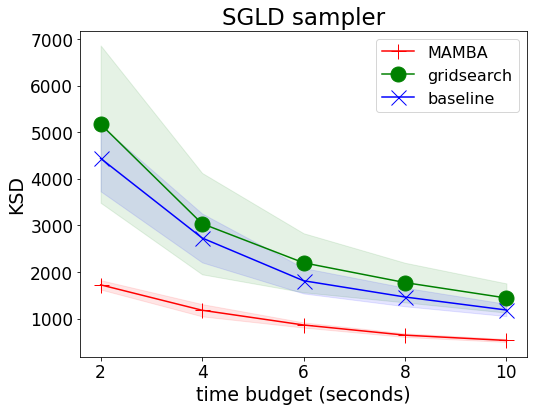

In [6]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgld_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_baseline+2*sd_ksd_curve_sgld_baseline, 
                 mean_ksd_curve_sgld_baseline-2*sd_ksd_curve_sgld_baseline, alpha=0.1, color='b')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

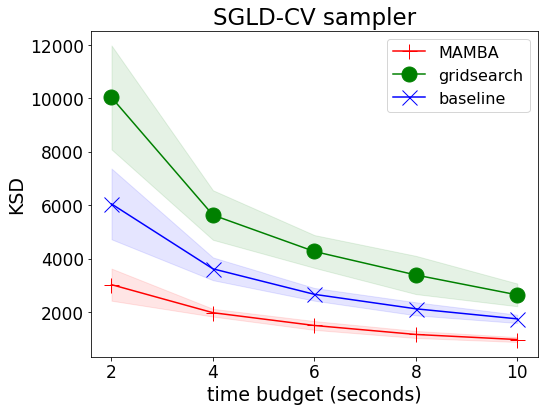

In [7]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_baseline+2*sd_ksd_curve_sgldCV_baseline, 
                 mean_ksd_curve_sgldCV_baseline-2*sd_ksd_curve_sgldCV_baseline, alpha=0.1, color='b')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

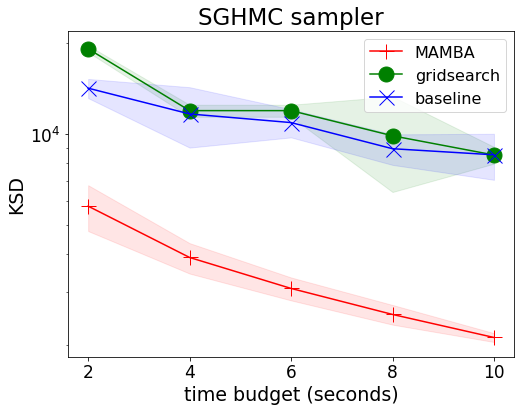

In [8]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_baseline+2*sd_ksd_curve_sghmc_baseline, 
                 mean_ksd_curve_sghmc_baseline-2*sd_ksd_curve_sghmc_baseline, alpha=0.1, color='b')


plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

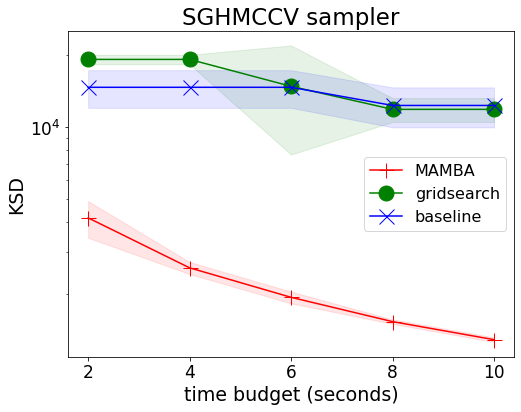

In [9]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_baseline+2*sd_ksd_curve_sghmcCV_baseline, 
                 mean_ksd_curve_sghmcCV_baseline-2*sd_ksd_curve_sghmcCV_baseline, alpha=0.1, color='b')

plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

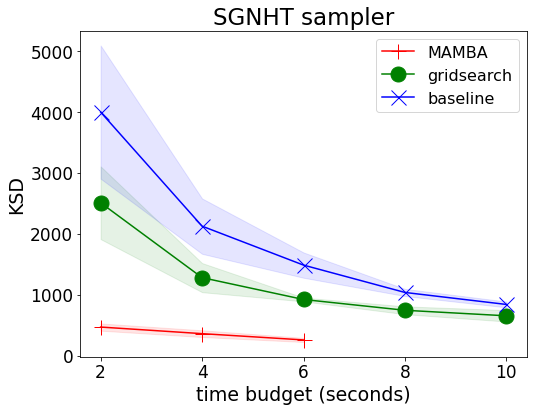

In [10]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_baseline+2*sd_ksd_curve_sgnht_baseline, 
                 mean_ksd_curve_sgnht_baseline-2*sd_ksd_curve_sgnht_baseline, alpha=0.1, color='b')


plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

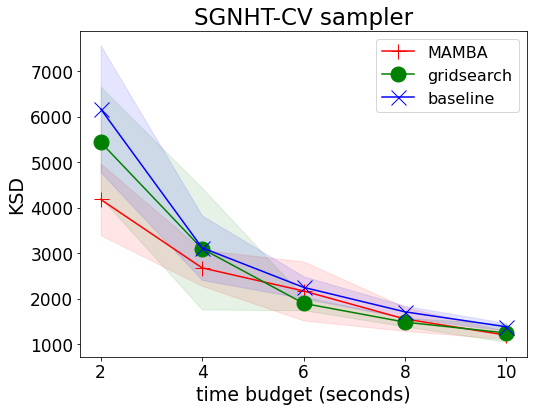

In [11]:
plt.rcParams.update({'font.size':17})

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_baseline+2*sd_ksd_curve_sgnhtCV_baseline, 
                 mean_ksd_curve_sgnhtCV_baseline-2*sd_ksd_curve_sgnhtCV_baseline, alpha=0.1, color='b')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")